# Create Globes to Display Global Gravity Data

*Joseph Barraud*

This notebook explains how to make maps in orthographic projection with `matplotlib basemap` and `cartopy`. The `interpies` library is also used to load the data and create images. `interpies` is available [here](https://github.com/jobar8/interpies).

**Note**: For this notebook to work, you need to install `interpies` and its dependencies, as well as `basemap` and `cartopy`. Using `conda`, that should be as easy as writing:

```bash
conda install basemap
conda install cartopy
```

---
The [orthographic projection](https://en.wikipedia.org/wiki/Orthographic_projection_in_cartography) is typically the one that results in an image of the Earth as a globe floating in space. Provided you have the right image, it is relatively easy to warp it around the globe and make a map that looks both interesting and unusual.

Let's start by importing the `interpies` module, `basemap`, `cartopy` and a few others.

In [1]:
import sys, os
import numpy as np
import imageio
from matplotlib import pyplot as plt

# basemap
from mpl_toolkits.basemap import Basemap

# cartopy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# interpies
import interpies
interpies.__version__

'0.3.1'

In [2]:
# plot within the notebook
%matplotlib inline

## Basic globe

This first example simply shows the setup for creating a map in orthographic projection. Both `basemap` and `cartopy` provide coastlines and other vector layers to add some context.

### With `basemap`
The orientation of the globe is controlled by the two parameters `lat_0` and `lon_0`.

C:\Anaconda3\envs\interpies_test\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


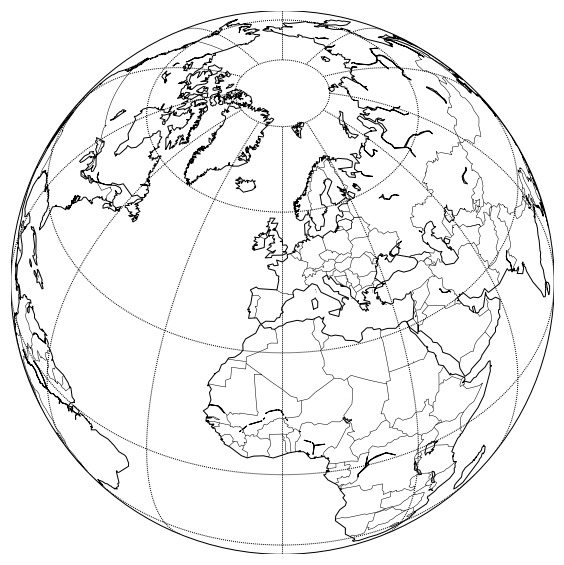

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(projection='ortho', lat_0=45, lon_0=0, resolution='c', ax=ax)

# draw coastlines and borders
m.drawcoastlines()
m.drawcountries()

# draw meridians and parallels
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
plt.show()

### With `cartopy`

Similarly, the orientation of the globe is controlled by parameters of the projection class.

Regarding meridians and parallels, the defaults are different but I tried to reproduce the behaviour of `basemap` here.

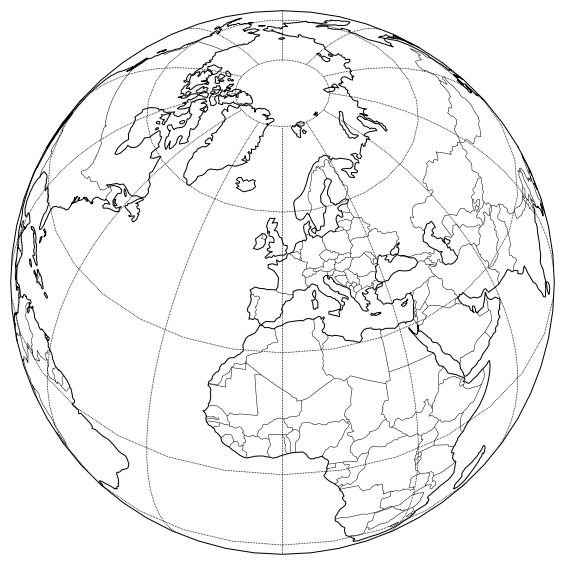

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 45))

# draw coastlines and borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, lw=0.5)
# draw meridians and parallels
gl = ax.gridlines(color='k', linestyle=(0, (1, 1)), xlocs=range(0,390,30), ylocs=[-80, -60, -30, 0, 30, 60, 80])

## Globe with ETOPO image

`basemap` has a built-in function to add the Global Relief Model [ETOPO](https://www.ngdc.noaa.gov/mgg/global/) from the NOAA to the map. There is also a similar function to display the Blue Marble image from NASA.

C:\Anaconda3\envs\interpies_test\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


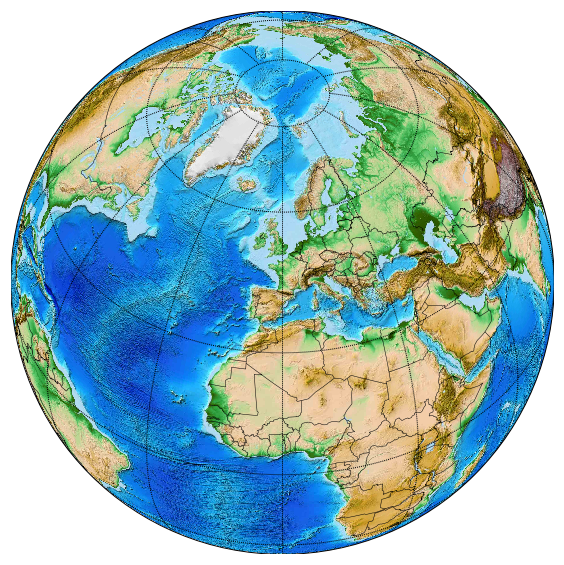

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(projection='ortho', lat_0=45, lon_0=0, resolution='l', ax=ax)
m.etopo()
# draw borders only
m.drawcountries()
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
plt.show()

## Globe with Natural Earth shaded relief image

`cartopy` makes use of [Natural Earth](http://www.naturalearthdata.com) data for its default background image.

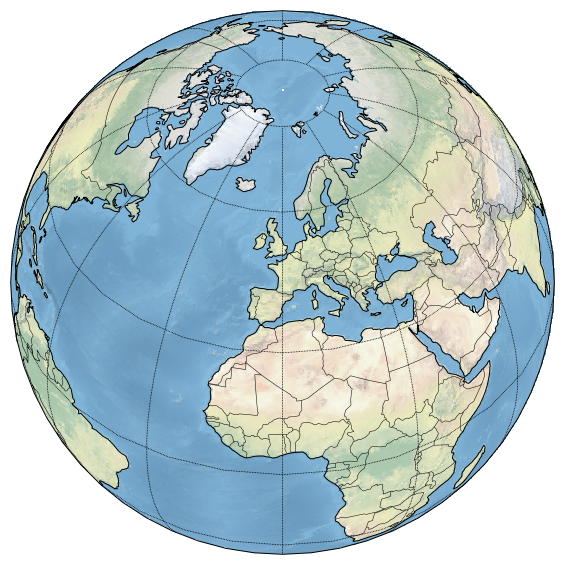

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 45))
# add shaded relief image
ax.stock_img()
# draw coastlines and borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, lw=0.5)
# draw meridians and parallels
gl = ax.gridlines(color='k', linestyle=(0, (1, 1)), xlocs=range(0,390,30), ylocs=[-80, -60, -30, 0, 30, 60, 80])

## Globe with gravity anomalies

Now we want to display our own data in this orthographic projection. We need a global dataset, so let's try the satellite gravity anomaly map from the [Scripps Institution of Oceanography](http://topex.ucsd.edu/grav_outreach/index.html). The dataset is commonly known as Sandwell's marine gravity data (Sandwell et al., 2014, also NOAA and NGA).

In `basemap`, the function behind the `etopo` and `bluemarble` methods is `warpimage`: it takes an image and distorts it to fit the geometry of the map. In `cartopy`, the equivalent is the `imshow` method.

In both cases, the first thing to do is to create an image of the gravity anomaly map. As the original data is provided as a map in a Mercator projection, it needs to be "unprojected". The method I used to create a 5x5 min grid can be found [here](http://geophysicslabs.com/2017/11/03/how-to-load-ss-gravity-data-in-python/). However, since we don't need the full resolution for a global map, I resampled the grid further to a 10 minute cell size.

Using `interpies`, first load the data in a `Grid` object.

In [7]:
grid1 = interpies.open('../data/sandwell_grav_v24_10min.tif')

Next display the grid with the `show` method.

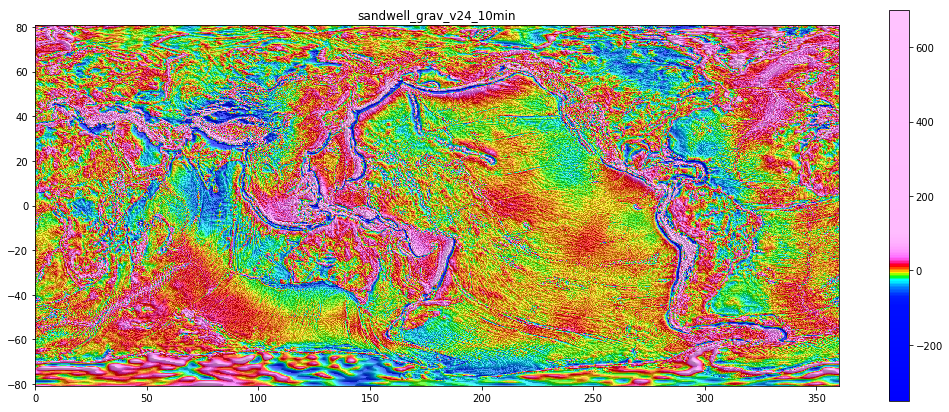

In [8]:
ax = grid1.show(figsize=(18, 12))

With `info`, we can see that the grid *does not* cover all the latitudes from -90 to +90, so we will have to deal with that later.

In [9]:
grid1.info()


* Info *
Grid name: sandwell_grav_v24_10min
Filename: ../data/sandwell_grav_v24_10min.tif
Coordinate reference system: epsg:4326
Grid size: 2160 columns x 969 rows
Cell size: 0.1667 x 0.1667
Lower left corner (pixel centre): (0.083, -80.679)
Grid extent (outer limits): west: 0.000, east: 360.000, south: -80.762, north: 80.738
No Data Value: -99999.0
Number of null cells: 0 (0.00%)

* Statistics *
mean = -0.2993307946330301
sigma = 31.987015187122367
min = -352.09283447265625
max = 699.9725952148438


### Export an image of map

But first, let's export an image of the map in a png format. Using the `save_image` method, one can create an image of the grid with hillshading and colours but without the labels and the colorbar. The function has the same parameters as `show`. Here, I am using `cmap_brightness` and `hs_contrast` to make the map a little bit brighter.

In [10]:
grid1.save_image('../data/grav_v24_10min.png', cmap_brightness=1.5, hs_contrast=3.0)

The grid was successfully saved as an image in ../data/grav_v24_10min.png


### Display the image on the globe with cartopy

In `cartopy`, the `imshow` method is used to display images on axes. The input is the RGB image created previously, so it needs to be loaded in an array.

In [11]:
im = imageio.imread('../data/grav_v24_10min.png')
im.shape

(969, 2160, 4)

The image has a fourth channel (alpha) that for some reason will create display problems with `imshow`. So it needs to be removed.

The other important parameter that needs tweaking is the extent. Reading from the grid info, it is `[west, east, south, north]`. However, `imshow` would not accept both `west=0` if `east=360`, so I added a tiny shift and started the grid at `west=0.001`.

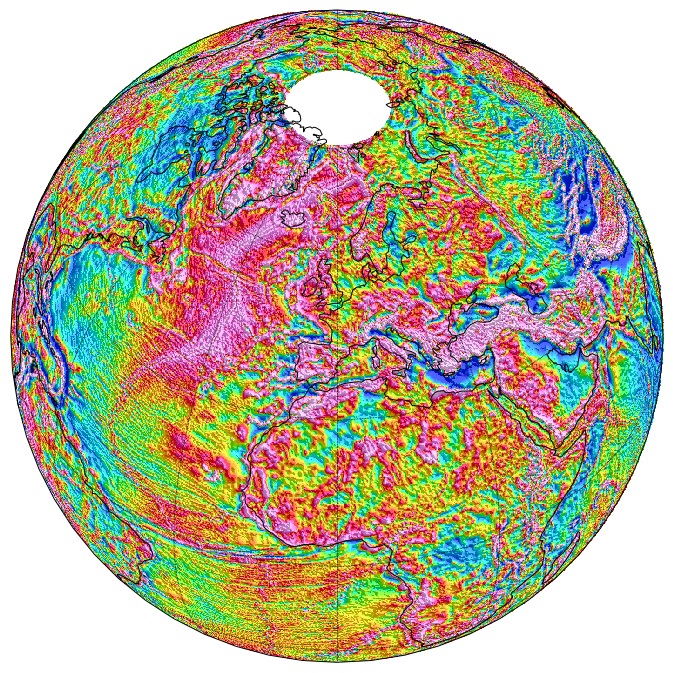

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.Orthographic(0, 45))
ax.imshow(im[:,:,:3], extent=[0.001, 360, -80.720, 80.738], origin='upper', transform=ccrs.PlateCarree())

# draw coastlines
ax.add_feature(cfeature.COASTLINE)
# draw meridians and parallels
gl = ax.gridlines(color='k', linestyle=(0, (1, 1)), xlocs=range(0,390,30), ylocs=[-80, -60, -30, 0, 30, 60, 80])

Here is another view:

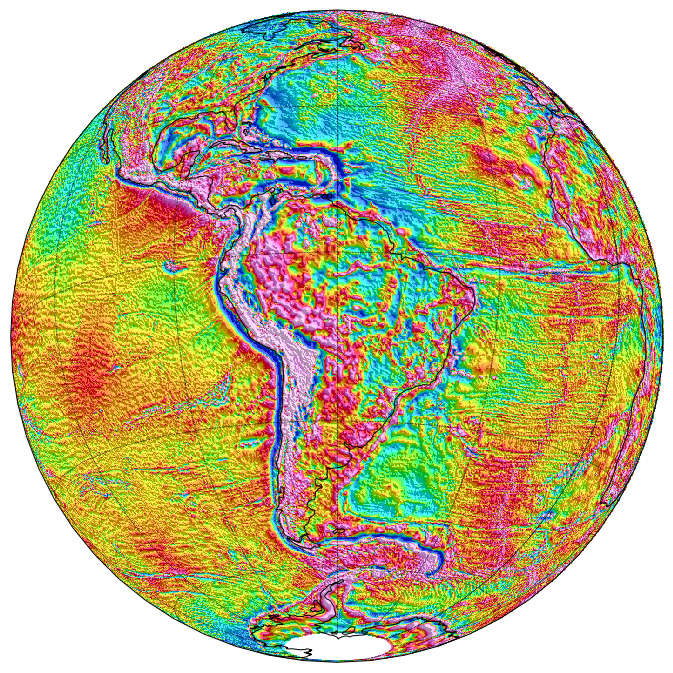

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.Orthographic(-60, -15))
ax.imshow(im[:,:,:3], extent=[0.001, 360, -80.720, 80.738], origin='upper', transform=ccrs.PlateCarree())

# draw coastlines
ax.add_feature(cfeature.COASTLINE)
# draw meridians and parallels
gl = ax.gridlines(color='k', linestyle=(0, (1, 1)), xlocs=range(0,390,30), ylocs=[-80, -60, -30, 0, 30, 60, 80])

### Display the image on the globe with basemap

Things are a little more complicated with `basemap`.


#### Pad image with white borders

From the [docstring of `warpimage`](http://matplotlib.org/basemap/api/basemap_api.html?highlight=warpimage#mpl_toolkits.basemap.Basemap.warpimage), we learn that the image needs to cover the entire globe and start at *-180W and the South Pole*.

In order to make sure the image covers the whole globe, we need to add some padding to fill the gap between the top and bottom edges of the image and the poles. With a cell size of 10 minutes (or 0.16666 degrees), a grid going from -90 to +90 would normally have 180/(10/60)=1080 rows. Our image has 969 rows, so 111 rows are missing. As this is an odd number, we cannot add the same number of rows on both sides. At that resolution, it shouldn't be a problem.

In [14]:
# add 56 rows at the top
im_pad = np.insert(im, 0, 255*np.ones((56, 2160, 4)), axis=0)
# add 55 rows at the bottom
im_pad = np.insert(im_pad, 969+56, 255*np.ones((55, 2160, 4)), axis=0)

Let's see the result:

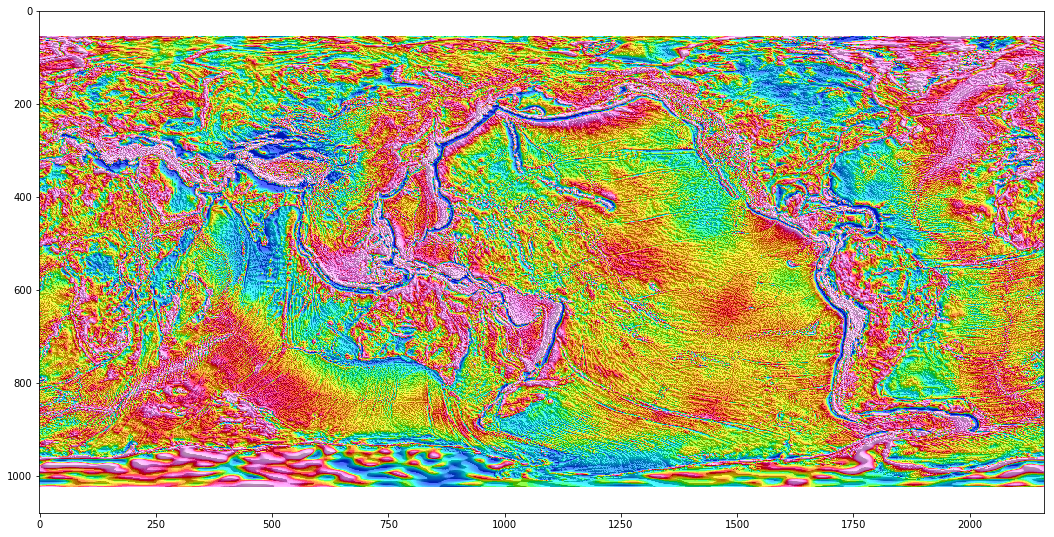

In [15]:
fig, ax = plt.subplots(figsize=(18,12))
ax.imshow(im_pad);

#### Shift the image by 180 degrees

According to the documentation, the global map should be centred on the Greenwich (0 degree) meridian. We can easily achieve that by using the `roll` function:

In [16]:
# roll
im_pad_roll = np.roll(im_pad, shift=(0, 1080, 0), axis=(0, 1, 2))

We can now use `warpimage` to display our padded image on the globe. One last thing however: the function requires the image to be read from a file. So let's save the previous image to a png file.

In [17]:
# Save the image
imageio.imwrite('../data/grav_v24_10min_pad_roll.png', im_pad_roll)

C:\Anaconda3\envs\interpies_test\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


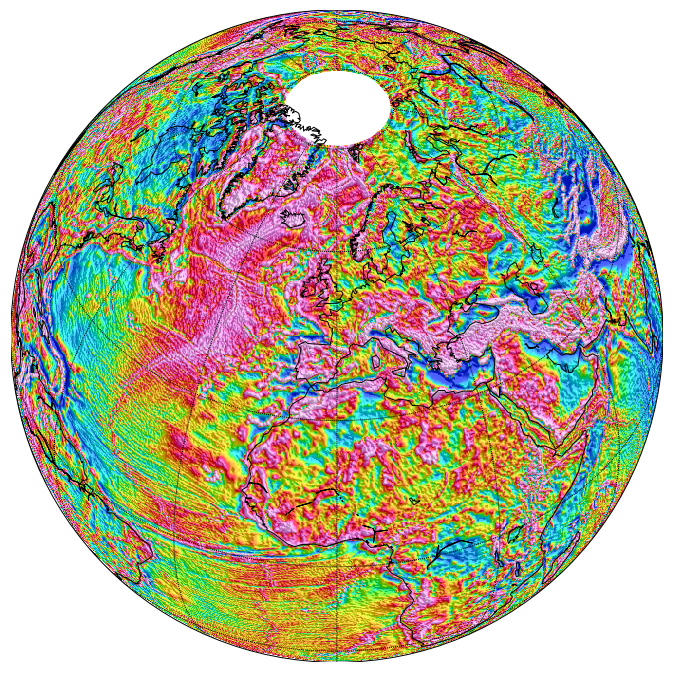

In [18]:
fig,ax = plt.subplots(figsize=(12, 12))
m = Basemap(projection='ortho', lat_0=45, lon_0=0, resolution='c', ax=ax)
m.warpimage(image='../data/grav_v24_10min_pad_roll.png')
# draw coastlines.
m.drawcoastlines()
# draw meridians and parallels
m.drawmeridians(np.arange(0, 360, 30))
m.drawparallels(np.arange(-90, 90, 30))
plt.show()

## Reference
Sandwell, D. T., R. D. Müller, W. H. F. Smith, E. Garcia, R. Francis. 2014. New global marine gravity model from CryoSat-2 and Jason-1 reveals buried tectonic structure, Science, Vol. 346, no. 6205, pp. 65-67, doi: 10.1126/science.1258213.